In [665]:
!jupyter trust week5.ipynb

Notebook already signed: week5.ipynb


In [607]:
import json
import folium
import requests
import pandas as pd
import numpy as np

from pandas import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

import warnings
warnings.filterwarnings('ignore')

In [608]:
# Getting the list of Neighborhood in Curitiba 
url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Curitiba'

In [609]:
# Examining the HTML
html = pd.read_html(url,header=2,decimal=',')
html

[          Bairro  Área (km²)  Homens Mulheres    Total  \
 0      Ganchinho        1120   3 667    3 658    7 325   
 1  Sitio Cercado        1112  50 631   51 779  102 410   
 2         Umbará        2247   7 280    7 315   14 595   
 
   Domicilios particulares  \
 0                   1 921   
 1                  27 914   
 2                  17 064   
 
    Rendimento mensal médio por responsáveis dos domicílios (R$)  
 0                                              76735             
 1                                              93495             
 2                                              90870             ,
            Bairro  Área (km²)  Homens Mulheres   Total  \
 0       Abranches         432   5 463    5 702  11 165   
 1           Atuba         427   6 156    6 476  12 632   
 2       Bacacheri         698  10 762   12 344  23 106   
 3     Bairro Alto         702  20 244   21 789  42 033   
 4     Barreirinha         373   8 079    8 942  17 021   
 5       Boa Vist

In [610]:
# We only need the first 8 dataframes
df = pd.concat(html[:9])

In [611]:
# Changing the name to english
df.columns = ['Neighborhood', 
              'Area', 
              'Men', 
              'Women', 
              'Total',
              'Private households',
              'Average_monthly_income']

In [612]:
# Resetting the index of the dataframe 
df.reset_index(drop=True, inplace=True)

In [613]:
# Final dataframe of Neighborhood's of Curitiba

In [614]:
df

,Neighborhood,Area,Men,Women,Total,Private households,Average_monthly_income
0,Ganchinho,1120,3 667,3 658,7 325,1 921,76735
1,Sitio Cercado,1112,50 631,51 779,102 410,27 914,93495
2,Umbará,2247,7 280,7 315,14 595,17 064,90870
3,Abranches,432,5 463,5 702,11 165,3 154,"1 009,67"
4,Atuba,427,6 156,6 476,12 632,3 627,"1 211,60"
...,...,...,...,...,...,...,...
71,Santo Inácio,272,2 940,3 097,6 037,1 683,"1 518,26"
72,São Braz,501,11 163,11 956,23 119,6 600,"1 206,50"
73,São João,303,1 441,1 509,2 950,814,"1 166,03"
74,Seminário,213,3 350,4 045,7 395,2 243,"3 210,65"


In [615]:
# Let's see if we have duplicated content.
# Looks like campo comprido is inserted two times, with same values.

df['Neighborhood'][df['Neighborhood'].duplicated()]

65    Campo Comprido
Name: Neighborhood, dtype: object

In [616]:
df = df.drop_duplicates().loc[:,:]

In [617]:
# The columns with valiues are all object, we need to convert them to numeric
# The spaces are filled with '\xa0', we need to replace them with empty spaces
# Finally, converting to int64

for column in df.columns[2:]:
    df[column] = df[column].astype('str').str.replace(',','').str.replace('\xa0','').astype('float64')
    # Transforming to string every row, replacing ',' with '.', replacing the '\xa0' space with '' and transforming
    # to float64

In [618]:
# Adjusting the Area and Average_monthly_income scale
df['Area'] = df['Area']/100
df['Average_monthly_income'] = df['Average_monthly_income']/100

In [619]:
# Creating a new feature
df['Men_Proportion'] = df['Men']/df['Total']
df['Women_Proportion'] = df['Women']/df['Total']

In [620]:
df

,Neighborhood,Area,Men,Women,Total,Private households,Average_monthly_income,Men_Proportion,Women_Proportion
0,Ganchinho,11.20,3667.0,3658.0,7325.0,1921.0,767.35,0.500614,0.499386
1,Sitio Cercado,11.12,50631.0,51779.0,102410.0,27914.0,934.95,0.494395,0.505605
2,Umbará,22.47,7280.0,7315.0,14595.0,17064.0,908.70,0.498801,0.501199
3,Abranches,4.32,5463.0,5702.0,11165.0,3154.0,1009.67,0.489297,0.510703
4,Atuba,4.27,6156.0,6476.0,12632.0,3627.0,1211.60,0.487334,0.512666
...,...,...,...,...,...,...,...,...,...
71,Santo Inácio,2.72,2940.0,3097.0,6037.0,1683.0,1518.26,0.486997,0.513003
72,São Braz,5.01,11163.0,11956.0,23119.0,6600.0,1206.50,0.482850,0.517150
73,São João,3.03,1441.0,1509.0,2950.0,814.0,1166.03,0.488475,0.511525
74,Seminário,2.13,3350.0,4045.0,7395.0,2243.0,3210.65,0.453009,0.546991


In [621]:
# Finding the Lat and Lon for the city of Curitiba

address = 'Curitiba, BR'

geolocator = Nominatim(user_agent="br_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Curitiba are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Curitiba are -25.4295963, -49.2712724.


In [622]:
for n in df['Neighborhood']:
    address = n+' , Curitiba, BR'
    geolocator = Nominatim(user_agent="br_explorer")
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        df.loc[df['Neighborhood'] == n, 'Latitude'] = latitude
        df.loc[df['Neighborhood'] == n, 'Longitude'] = longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(n,latitude, longitude))
    

The geograpical coordinate of Ganchinho are -25.5720763, -49.2636674.
The geograpical coordinate of Sitio Cercado are -25.5427012, -49.2691056.
The geograpical coordinate of Umbará are -25.5681693, -49.2856994.
The geograpical coordinate of Abranches are -25.3614742, -49.272054.
The geograpical coordinate of Atuba are -25.3875003, -49.2066058.
The geograpical coordinate of Bacacheri are -25.3968497, -49.2344563.
The geograpical coordinate of Bairro Alto are -25.4058225, -49.2076602.
The geograpical coordinate of Barreirinha are -25.3685642, -49.2604545.
The geograpical coordinate of Boa Vista are -25.4576591, -48.9292726.
The geograpical coordinate of Cachoeira are -25.3859144, -48.8600193.
The geograpical coordinate of Pilarzinho are -25.3963479, -49.2875575.
The geograpical coordinate of Santa Cândida are -25.3698739, -49.2305741.
The geograpical coordinate of São Lourenço are -25.3887613, -49.266281.
The geograpical coordinate of Taboão are -25.3733813, -49.2807648.
The geograpical 

In [623]:
# is NaN?
df[df.isna().any(axis=1)]

,Neighborhood,Area,Men,Women,Total,Private households,Average_monthly_income,Men_Proportion,Women_Proportion,Latitude,Longitude
42,Alto da XV,1.5,3835.0,4848.0,8683.0,3084.0,2612.08,0.441668,0.558332,NaN,NaN


In [624]:
# It's just one neighbouhood, so we can simplify looking at google maps!

df.loc[42,'Latitude'], df.loc[42,'Longitude'] = [-25.428019,-49.2593998]

In [625]:
df.isna().sum()

Neighborhood              0
Area                      0
Men                       0
Women                     0
Total                     0
Private households        0
Average_monthly_income    0
Men_Proportion            0
Women_Proportion          0
Latitude                  0
Longitude                 0
dtype: int64

In [626]:
# Now we have our dataframe of all neighborhood's in Curitiba and their our Lat and Lon
df

,Neighborhood,Area,Men,Women,Total,Private households,Average_monthly_income,Men_Proportion,Women_Proportion,Latitude,Longitude
0,Ganchinho,11.20,3667.0,3658.0,7325.0,1921.0,767.35,0.500614,0.499386,-25.572076,-49.263667
1,Sitio Cercado,11.12,50631.0,51779.0,102410.0,27914.0,934.95,0.494395,0.505605,-25.542701,-49.269106
2,Umbará,22.47,7280.0,7315.0,14595.0,17064.0,908.70,0.498801,0.501199,-25.568169,-49.285699
3,Abranches,4.32,5463.0,5702.0,11165.0,3154.0,1009.67,0.489297,0.510703,-25.361474,-49.272054
4,Atuba,4.27,6156.0,6476.0,12632.0,3627.0,1211.60,0.487334,0.512666,-25.387500,-49.206606
...,...,...,...,...,...,...,...,...,...,...,...
71,Santo Inácio,2.72,2940.0,3097.0,6037.0,1683.0,1518.26,0.486997,0.513003,-25.425206,-49.328578
72,São Braz,5.01,11163.0,11956.0,23119.0,6600.0,1206.50,0.482850,0.517150,-25.418226,-49.350834
73,São João,3.03,1441.0,1509.0,2950.0,814.0,1166.03,0.488475,0.511525,-25.391453,-49.311479
74,Seminário,2.13,3350.0,4045.0,7395.0,2243.0,3210.65,0.453009,0.546991,-25.448910,-49.305147


In [627]:
# Let's visualize Curitiba and their Neighbourhood's
map_cwb = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
for lat, lng, label in zip(df['Latitude'],df['Longitude'],df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cwb)

map_cwb

In [628]:
# Putting the ID of the Foursquare API

CLIENT_ID = 'MCUQ51RMII5N3H3TT4TJJHR4YHKBWXFXODIJ10OQKYNJQLK4' # your Foursquare ID
CLIENT_SECRET = 'U2UCICIBDF1QR0G4IJYYSWZTAAX05APVELSZCH4IZYFR05VT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MCUQ51RMII5N3H3TT4TJJHR4YHKBWXFXODIJ10OQKYNJQLK4
CLIENT_SECRET:U2UCICIBDF1QR0G4IJYYSWZTAAX05APVELSZCH4IZYFR05VT


In [629]:
# Testing for the first neighborhood

neighborhood_latitude = df.loc[20,'Latitude']
neighborhood_longitude = df.loc[20,'Longitude']
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=MCUQ51RMII5N3H3TT4TJJHR4YHKBWXFXODIJ10OQKYNJQLK4&client_secret=U2UCICIBDF1QR0G4IJYYSWZTAAX05APVELSZCH4IZYFR05VT&v=20180605&ll=-25.4533496,-49.2130027&radius=500&limit=100'

In [630]:
# This is the path to each venue 
venues = results['response']['groups'][0]['items'][0]['venue']
nearby_venues = json_normalize(venues) #json to dataframe

nearby_venues

,id,name,categories,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,photos.count,photos.groups
0,4e45e0c3ae60fa7232ecded6,Justino Pizza Bar,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...","R. Cap. Guilherme Bianchi, 484",-25.456264,-49.211033,"[{'label': 'display', 'lat': -25.4562642801932...",380,82930-090,BR,Curitiba,PR,Brasil,"[R. Cap. Guilherme Bianchi, 484, Curitiba, PR,...",0,[]


In [631]:
# Now let's apply this to every neighboorhood and venues

def getNearbyVenues(names, latitudes, longitudes, radius=750):
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Return only relevante information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            res['venue']['name'],
            res['venue']['location']['lat'],
            res['venue']['location']['lng'],
            res['venue']['categories'][0]['name']) for res in results])

    nearby_venues = pd.DataFrame(item for venue_list in venues_list for item in venue_list)
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [632]:
curitiba_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Ganchinho
Sitio Cercado
Umbará
Abranches
Atuba
Bacacheri
Bairro Alto
Barreirinha
Boa Vista
Cachoeira
Pilarzinho
Santa Cândida
São Lourenço
Taboão
Tarumã
Tingui
Alto Boqueirão
Boqueirão
Hauer
Xaxim
Cajuru
Capão da Imbuia
Guabirotuba
Jd. das Américas
Uberaba
Augusta
Cidade Industrial
Riviera
São Miguel
Água Verde
Campo Comprido
Fanny
Fazendinha
Guaíra
Lindoia
Novo Mundo
Parolin
Portão
Santa Quitéria
Vila Izabel
Ahú
Alto da Glória
Alto da XV
Batel
Bigorrilho
Bom Retiro
Cabral
Centro
Centro Cívico
Cristo Rei
Hugo Lange
Jardim Botânico
Jardim Social
Juvevê
Mercês
Prado Velho
Rebouças
São Francisco
Campo de Santana
Capão Raso
Caximba
Pinheirinho
Tatuquara
Butiatuvinha
Campina do Siqueira
Cascatinha
Lamenha Pequena
Mossunguê
Orleans
Santa Felicidade
Santo Inácio
São Braz
São João
Seminário
Vista Alegre


In [633]:
# Dataframe with venues of each Neighborhood
curitiba_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ganchinho,-25.572076,-49.263667,Parque Lago Azul,-25.574436,-49.268250,Park
1,Ganchinho,-25.572076,-49.263667,Frigorífico Família Costa,-25.567643,-49.262300,Steakhouse
2,Ganchinho,-25.572076,-49.263667,Defumados Ganchinho,-25.569211,-49.265118,Steakhouse
3,Ganchinho,-25.572076,-49.263667,Bistrô Lago Azul,-25.573259,-49.267888,Brazilian Restaurant
4,Ganchinho,-25.572076,-49.263667,Jardim Recanto Feliz,-25.568017,-49.264192,Housing Development
...,...,...,...,...,...,...,...
2773,Vista Alegre,-25.406766,-49.295578,Clínica Veterinária Farol,-25.411304,-49.291813,Pet Store
2774,Vista Alegre,-25.406766,-49.295578,Cantinho Brasileiro,-25.403694,-49.289757,Southern Brazilian Restaurant
2775,Vista Alegre,-25.406766,-49.295578,Formighieri Madeiras,-25.412137,-49.292181,Furniture / Home Store
2776,Vista Alegre,-25.406766,-49.295578,Rafa Pizzaria,-25.404383,-49.289087,Pizza Place


In [634]:
# Let's see if we have all the neighborhoods

unknow_venues = list(set(df['Neighborhood']).difference(curitiba_venues['Neighborhood'].value_counts().index))
unknow_venues
# These four doens't have values, so we gonna insert mannualy a ''unknow venues'' column in the future

['Campo de Santana', 'Boa Vista', 'Fazendinha', 'São Miguel']

In [635]:
# How much venues in each Neighborhood?
curitiba_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abranches,4,4,4,4,4,4
Ahú,54,54,54,54,54,54
Alto Boqueirão,11,11,11,11,11,11
Alto da Glória,100,100,100,100,100,100
Alto da XV,90,90,90,90,90,90
...,...,...,...,...,...,...
Umbará,9,9,9,9,9,9
Vila Izabel,60,60,60,60,60,60
Vista Alegre,20,20,20,20,20,20


In [636]:
# Some neighborhoods are very unbalanced, but we will work with these numbers anyway
curitiba_venues['Neighborhood'].value_counts().unique()

array([100,  97,  94,  90,  82,  78,  76,  65,  63,  60,  59,  55,  54,
        49,  47,  43,  42,  40,  38,  37,  35,  34,  30,  29,  28,  26,
        22,  21,  20,  18,  17,  16,  15,  14,  11,  10,   9,   8,   6,
         5,   4,   3,   2,   1], dtype=int64)

In [637]:
print('There are {} uniques categories.'.format(len(curitiba_venues['Venue Category'].unique())))

There are 274 uniques categories.


In [638]:
curitiba_onehot = pd.get_dummies(curitiba_venues[['Venue Category']], prefix="", prefix_sep="")

# There is a feature named ''Neighborhood'' so i decided to name the neighborhood as 'Neighborhood_Label'
curitiba_onehot.insert(0, 'Neighborhood_Label' ,curitiba_venues['Neighborhood'])
# Inserting to the first position

curitiba_onehot.head()

,Neighborhood_Label,Acai House,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Ganchinho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ganchinho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ganchinho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ganchinho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ganchinho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [639]:
curitiba_onehot.shape

(2778, 275)

In [640]:
# Grouping every neighborhood and taking the mean of frequency of each category

curitiba_grouped = curitiba_onehot.groupby('Neighborhood_Label').mean().reset_index()
curitiba_grouped

,Neighborhood_Label,Acai House,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Abranches,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
1,Ahú,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.018519,0.0,0.0,0.0,0.00
2,Alto Boqueirão,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
3,Alto da Glória,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.01
4,Alto da XV,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,Umbará,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
67,Vila Izabel,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
68,Vista Alegre,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
69,Xaxim,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00


In [641]:
curitiba_grouped.shape

(71, 275)

In [642]:
unknow_venues_df = pd.DataFrame({'Neighborhood_Label':unknow_venues})
unknow_venues_df

,Neighborhood_Label
0,Campo de Santana
1,Boa Vista
2,Fazendinha
3,São Miguel


In [643]:
# Let's implement the Neighborhoods with none values

unknow_venues_df = pd.DataFrame({'Neighborhood_Label':unknow_venues})

curitiba_grouped_final = pd.concat([curitiba_grouped,unknow_venues_df], axis = 0)

In [644]:
curitiba_grouped_final.isna().sum(axis=1) # Only the four in the ending have NaN values, let's fill with 0

0       0
1       0
2       0
3       0
4       0
     ... 
70      0
0     274
1     274
2     274
3     274
Length: 75, dtype: int64

In [645]:
curitiba_grouped_final = curitiba_grouped_final.fillna(0).reset_index(drop=True)

In [646]:
# Finnaly we have the dataframe with all the neighbourhoods and all the features
curitiba_grouped_final 

,Neighborhood_Label,Acai House,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Abranches,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
1,Ahú,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.00
2,Alto Boqueirão,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
3,Alto da Glória,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01
4,Alto da XV,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Água Verde,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
71,Campo de Santana,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
72,Boa Vista,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00
73,Fazendinha,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00


In [647]:
# 75 neighborhoods with 275 features!

In [648]:
# Let's reduce that to the top 5 common venues!

num_top_venues = 5

for hood in curitiba_grouped_final['Neighborhood_Label']:
    print("----"+hood+"----")
    temp = curitiba_grouped_final[curitiba_grouped_final['Neighborhood_Label'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abranches----
          venue  freq
0         Motel  0.50
1          Farm  0.25
2  Soccer Field  0.25
3    Acai House  0.00
4  Noodle House  0.00


----Ahú----
                  venue  freq
0            Restaurant  0.07
1           Pizza Place  0.07
2  Gym / Fitness Center  0.06
3    Italian Restaurant  0.04
4             Pet Store  0.04


----Alto Boqueirão----
                  venue  freq
0                Bakery  0.18
1         Hot Dog Joint  0.18
2  Gym / Fitness Center  0.18
3         Train Station  0.09
4         Grocery Store  0.09


----Alto da Glória----
                  venue  freq
0  Brazilian Restaurant  0.08
1                  Café  0.07
2           Pizza Place  0.04
3    Italian Restaurant  0.03
4              Pharmacy  0.03


----Alto da XV----
                  venue  freq
0  Brazilian Restaurant  0.08
1           Coffee Shop  0.07
2               Theater  0.06
3                  Café  0.04
4           Snack Place  0.04


----Atuba----
            venue  freq
0    

4                Hostel  0.03


----São João----
                venue  freq
0               Track   0.2
1          Playground   0.2
2        Fishing Spot   0.2
3     Border Crossing   0.2
4  Athletics & Sports   0.2


----São Lourenço----
          venue  freq
0  Soccer Field  0.12
1       Theater  0.08
2          Park  0.05
3    Skate Park  0.05
4        Bakery  0.05


----Taboão----
                  venue  freq
0           Snack Place   0.4
1            Food Truck   0.1
2                 Plaza   0.1
3             Juice Bar   0.1
4  Brazilian Restaurant   0.1


----Tarumã----
            venue  freq
0     Pizza Place  0.25
1       Racetrack  0.12
2        Bus Stop  0.12
3       Nightclub  0.12
4  Sandwich Place  0.12


----Tatuquara----
               venue  freq
0                Pub   0.5
1               Pool   0.5
2          Nightclub   0.0
3  Other Repair Shop   0.0
4    Organic Grocery   0.0


----Tingui----
               venue  freq
0        Pizza Place  0.09
1     Ice Cream S

In [649]:
# Using a function to sorte the venues
# Sorting the venues in order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [650]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_Label']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
curitiba_venues_sorted = pd.DataFrame(columns=columns)
curitiba_venues_sorted['Neighborhood_Label'] = curitiba_grouped_final['Neighborhood_Label']

for ind in np.arange(curitiba_grouped_final.shape[0]):
    curitiba_venues_sorted.iloc[ind, 1:] = return_most_common_venues(curitiba_grouped_final.iloc[ind, :], num_top_venues)

curitiba_venues_sorted.head(10)

,Neighborhood_Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abranches,Motel,Farm,Soccer Field,Yoga Studio,Fish Market,Factory,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot
1,Ahú,Restaurant,Pizza Place,Gym / Fitness Center,Italian Restaurant,Pet Store,Pharmacy,Fried Chicken Joint,Café,Steakhouse,BBQ Joint
2,Alto Boqueirão,Bakery,Hot Dog Joint,Gym / Fitness Center,Pizza Place,Grocery Store,Supermarket,Arts & Crafts Store,Train Station,Farmers Market,Event Space
3,Alto da Glória,Brazilian Restaurant,Café,Pizza Place,Buffet,Bar,Restaurant,Pharmacy,Italian Restaurant,Asian Restaurant,Beer Bar
4,Alto da XV,Brazilian Restaurant,Coffee Shop,Theater,Snack Place,Café,Middle Eastern Restaurant,Chinese Restaurant,Restaurant,Bistro,Soccer Stadium
5,Atuba,Café,Bakery,Hotel,Hardware Store,Brazilian Restaurant,Food Truck,Steakhouse,Sandwich Place,Restaurant,Coffee Shop
6,Augusta,Ice Cream Shop,Park,Lake,Empanada Restaurant,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
7,Bacacheri,Bar,Bakery,Pharmacy,Gym,Hot Dog Joint,Pizza Place,Sandwich Place,Brewery,Fruit & Vegetable Store,Restaurant
8,Bairro Alto,Pizza Place,Hot Dog Joint,BBQ Joint,Pharmacy,Public Art,Restaurant,Sandwich Place,Motorcycle Shop,Tapiocaria,Gift Shop
9,Barreirinha,Bakery,Pizza Place,Pharmacy,Ice Cream Shop,Steakhouse,Grocery Store,Fish & Chips Shop,Park,Restaurant,Deli / Bodega


In [651]:
# This table was just for epxloration purposes,
# Now we can use the original table (with the dummies variables) to cluster
# each neighbourhood

In [652]:
curitiba_grouped_cluster = curitiba_grouped_final.drop('Neighborhood_Label',1)

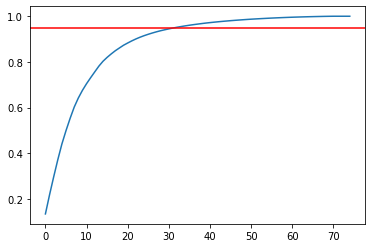

In [653]:
# Let's reduce the dimensionality for better use of KMeans

from sklearn.decomposition import PCA

pca = PCA()

pca.fit(curitiba_grouped_cluster)

plt.plot(range(pca.explained_variance_ratio_.shape[0]), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.95, color='red')

# We can use aprox 30 features to explain 95% of variability 

In [654]:
pca = PCA(30)
curitiba_grouped_cluster = pca.fit_transform(curitiba_grouped_cluster)
curitiba_grouped_cluster.shape

(75, 30)

In [655]:
# Let's try diffent K values:

from sklearn.cluster import KMeans

kclusters = range(1,20)

inertia_list = []

for k in kclusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(curitiba_grouped_cluster)
    inertia_list.append(kmeans.inertia_)


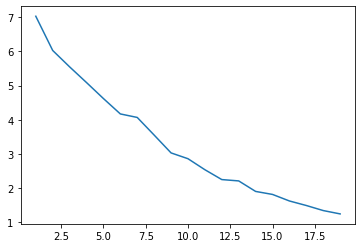

In [656]:
plt.plot(kclusters, inertia_list)

In [657]:
# We can see the number is beggining to descrease slower in between 10 and 15 cluster
# We have 75 neighborhoods, so i will choose 12 K 

In [658]:
n_clusters = 12
kmeans = KMeans(n_clusters)
kmeans.fit(curitiba_grouped_cluster)

# Add clustering labels

curitiba_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

df_merged = df.copy()

df_merged = df_merged.join(curitiba_venues_sorted.set_index('Neighborhood_Label'), on='Neighborhood')

In [659]:
df_merged

,Neighborhood,Area,Men,Women,Total,Private households,Average_monthly_income,Men_Proportion,Women_Proportion,Latitude,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ganchinho,11.20,3667.0,3658.0,7325.0,1921.0,767.35,0.500614,0.499386,-25.572076,...,Steakhouse,Brazilian Restaurant,Housing Development,Park,Fish & Chips Shop,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant
1,Sitio Cercado,11.12,50631.0,51779.0,102410.0,27914.0,934.95,0.494395,0.505605,-25.542701,...,Bakery,Ice Cream Shop,Restaurant,Burger Joint,Smoke Shop,Bistro,Metro Station,Brazilian Restaurant,Garden Center,Park
2,Umbará,22.47,7280.0,7315.0,14595.0,17064.0,908.70,0.498801,0.501199,-25.568169,...,Video Store,Electronics Store,Bakery,Gym / Fitness Center,Supermarket,Bar,Pizza Place,Flea Market,Flower Shop,Fishing Spot
3,Abranches,4.32,5463.0,5702.0,11165.0,3154.0,1009.67,0.489297,0.510703,-25.361474,...,Motel,Farm,Soccer Field,Yoga Studio,Fish Market,Factory,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot
4,Atuba,4.27,6156.0,6476.0,12632.0,3627.0,1211.60,0.487334,0.512666,-25.387500,...,Café,Bakery,Hotel,Hardware Store,Brazilian Restaurant,Food Truck,Steakhouse,Sandwich Place,Restaurant,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Santo Inácio,2.72,2940.0,3097.0,6037.0,1683.0,1518.26,0.486997,0.513003,-25.425206,...,Bakery,General Entertainment,Organic Grocery,Factory,Bar,Flower Shop,Flea Market,Fishing Spot,Fish Market,Food Truck
72,São Braz,5.01,11163.0,11956.0,23119.0,6600.0,1206.50,0.482850,0.517150,-25.418226,...,Pizza Place,Gym / Fitness Center,Furniture / Home Store,Steakhouse,Gym,Sandwich Place,Big Box Store,Snack Place,Breakfast Spot,Recreation Center
73,São João,3.03,1441.0,1509.0,2950.0,814.0,1166.03,0.488475,0.511525,-25.391453,...,Fishing Spot,Playground,Border Crossing,Track,Athletics & Sports,Fish & Chips Shop,Factory,Farm,Farmers Market,Fast Food Restaurant
74,Seminário,2.13,3350.0,4045.0,7395.0,2243.0,3210.65,0.453009,0.546991,-25.448910,...,Bar,Pharmacy,Burger Joint,Pet Store,Pizza Place,Paper / Office Supplies Store,Churrascaria,Buffet,Bakery,Brazilian Restaurant


In [660]:
# Clusters!

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters